This is script will figure out travel times from different runs

In [1]:
import argparse
import pandas

# declare some column names
travelTime = 'travelTime'
startTime = 'startTime'
endTime = 'endTime'
distance = 'distance'
id = 'personId'
tripNumber = 'tripNo'
mode = 'mainMode'

def parse_args(args):
    parser = argparse.ArgumentParser()
    parser.add_argument('-f', '--files', nargs='+', required=True)
    parser.add_argument('-n', '--names', nargs='+', required=True)
    return parser.parse_args(args)

def read_csv(listOfFiles, listOfNames):
    
    assert(len(listOfFiles) == len(listOfNames)), 'number of files and scenario names should be equal but was: (' + str(len(listOfFiles)) + '/' + str(len(listOfNames)) + ')'
    
    result = []

    for file, name in zip(listOfFiles, listOfNames):
        scenario = pandas.read_csv(file, usecols=[id, tripNumber, startTime, endTime, distance, mode])
        scenario.set_index([id, tripNumber], inplace=True)
        scenario.sort_index(inplace=True)
        scenario[travelTime] = scenario[endTime] - scenario[startTime]
        result.append(scenario)
    return result

In [2]:
dataPath = "C:\\Users\\Janekdererste\\Desktop\\deurb\\trips\\"
args = parse_args([
    '-f', dataPath + '10pct.csv', dataPath + '20pct.csv',dataPath + '30pct.csv', dataPath + '40pct.csv', dataPath + '50pct.csv',dataPath + '60pct.csv',dataPath + '70pct.csv', dataPath + '80pct.csv',dataPath + '90pct.csv',
    '-n', '10%', '20%','30%', '40%', '50%','60%','70%','80%','90%',
])

dataFrames = read_csv(args.files, args.names)
data = pandas.concat(dataFrames, keys=args.names, names=['RunId', id, tripNumber])
#print(data.head(10))
data.head(10)

startTime  endTime      distance mainMode  travelTime
RunId personId tripNo                                                       
10%   54804601 0         24903.0  25374.0    596.417752     walk       471.0
               1         32565.0  33015.0    569.168372     walk       450.0
               2         33015.0  33218.0    256.803636     walk       203.0
               3         41131.0  41401.0    341.966519     walk       270.0
               4         41401.0  41916.0    651.419213     walk       515.0
               5         41916.0  42282.0    462.779612     walk       366.0
      54822301 0         20203.0  25825.0  19557.258771     bike      5622.0
               1         45501.0  48597.0   9387.154289     bike      3096.0
               2         52251.0  55629.0  12239.582256     bike      3378.0
      54847601 0         11787.0  14509.0  30006.526513      car      2722.0

In [3]:
#filter unplausible walk trips
data['speed'] = data[distance] / data[travelTime]
filtered = data.query('speed > 1 and speed < 2')
# select the mode and the travel time
travelTimes = data[[travelTime, mode]]


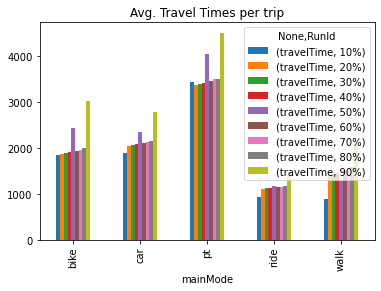

In [4]:
# group by mode and by run id
grouped = travelTimes.groupby([mode, 'RunId']).mean()
# unstack the multi-index into two columns for both run ids and then plot
grouped.unstack(level='RunId').plot.bar(title='Avg. Travel Times per trip')

In [5]:
# compute time differences between base and scenario-case
baseCase = 'Basisfall'
policyCase = 'Deurb-50'
unstacked_travel_times = travelTimes.unstack(level='RunId')
unstacked_travel_times['time difference'] = unstacked_travel_times[travelTime, policyCase] - unstacked_travel_times[travelTime, baseCase]

# select trips which have the same mode in both scenarios
is_same_mode = unstacked_travel_times[mode, baseCase] == unstacked_travel_times[mode, policyCase]
differences_same_mode = unstacked_travel_times[is_same_mode]

#print(differences_same_mode)

baseCaseMainMode = differences_same_mode.xs([(mode, baseCase), ('time difference','')], axis=1)
mean = baseCaseMainMode.groupby((mode, baseCase)).mean()
mean.plot.bar(title='Mean trip time difference not changed')

KeyError: ('travelTime', 'Deurb-50')

In [ ]:
# select the ones which have different modes in scenario and base case
is_not_same_mode = unstacked_travel_times[mode, baseCase] != unstacked_travel_times[mode, policyCase]
different_mode = unstacked_travel_times[is_not_same_mode]

#print(different_mode)

baseCaseMainMode = different_mode.xs([(mode, baseCase),(mode, policyCase), ('time difference', '')], axis=1)
mean = baseCaseMainMode.groupby([(mode, baseCase), (mode, policyCase)]).mean()
mean.plot.bar(title='time difference, Changer (mean)')